In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import logging
import matplotlib.pyplot as plt
import json
import pickle
from itertools import product
from tqdm import tqdm
import numpy as np

# Add the project root to the system path using the current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import using absolute path from project root
from src.instances.chain_instance import ARBITRUM_DTO, OPTIMISM_DTO, ETHEREUM_DTO, BASE_DTO
from src.instances.aave_instance import AaveArbitrum, AaveOptimism, AaveEthereum, AaveBase
from src.models.token import TokenDTO
from src.models.trade_pair import PairDTO


2024-12-15 19:30:24,129 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Arbitrum
2024-12-15 19:30:24,130 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Optimism
2024-12-15 19:30:24,130 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Ethereum
2024-12-15 19:30:24,131 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Base


In [3]:
from src.scripts.process_stored_data_aave import update_trade_pair_exchange_price, \
    create_liquidatable_user_data_series, create_health_ratio_data_emode, create_asset_mapping, \
    create_health_ratio_data, create_liquidatable_user_data, scale_supply_and_create_liquidations, \
    create_liquidations_v2, scale_price_and_identify_liquidatable_collateral


In [4]:
chain_object_mapping = {
    'ethereum': [ETHEREUM_DTO, AaveEthereum],
    'arbitrum': [ARBITRUM_DTO, AaveArbitrum],
    'optimism': [OPTIMISM_DTO, AaveOptimism],
    'base': [BASE_DTO, AaveBase]
}

In [5]:
CHOOSEN_CHAIN = 'ethereum'
AAVE_EMODE_LT = 0.95
ASSET_UNDER_CONSIDERATION = "wstETH"
EMODE_SWITCH = False
ASSET_UNDER_CONSIDERATION_CURVE = 'wstETH'
SOFT_LIQUIDATION_EFFICIENCY = 0.80
PRICE_DROP_FACTOR = 0.85



if CHOOSEN_CHAIN not in chain_object_mapping:
    print("Invalid chain chosen.")
    exit(1)
else:
    chain_instance, aave_instance = chain_object_mapping[CHOOSEN_CHAIN]


In [6]:
if not os.path.exists('aave_supported_asset_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_supported_asset_data = aave_instance.get_aave_supported_asset_data()
    print("Saving to file.")
    aave_supported_asset_data.to_csv('aave_supported_asset_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_supported_asset_data = pd.read_csv('aave_supported_asset_data.csv')


File found. Reading from file.


In [7]:
if not os.path.exists('aave_user_position_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_user_position_data = aave_instance.get_user_position_data(aave_supported_asset_data)
    print("Saving to file.")
    aave_user_position_data.to_csv('aave_user_position_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_user_position_data = pd.read_csv('aave_user_position_data.csv')


if not EMODE_SWITCH:
    # Filter out 0 from emode column
    aave_user_position_data = aave_user_position_data[aave_user_position_data['emode'] == 0]

File found. Reading from file.


In [8]:
aave_asset_object_dict = {}

for _, row in tqdm(aave_supported_asset_data.iterrows(), total=len(aave_supported_asset_data), desc="Creating TokenDTO objects"):
    token = TokenDTO(
        address=row['assetAddress'],
        name=row['symbol'],
        symbol=row['symbol'],
        decimals=row['decimals'],
        chain=chain_instance,
        price=row['price'],
    )
    aave_asset_object_dict[row['symbol']] = token

steth_token = TokenDTO(
        address='0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84',
        name='Liquid staked Ether 2.0',
        symbol='stETH',
        decimals=18,
        chain=ETHEREUM_DTO,
    )
aave_asset_object_dict['stETH'] = steth_token

Creating TokenDTO objects: 100%|██████████| 37/37 [00:09<00:00,  4.03it/s]


In [9]:
current_price_mapping = {}
for index, asset in aave_supported_asset_data.iterrows():
    current_price_mapping[asset['symbol']] = asset['price']

In [10]:
# liquidatable_price_df = scale_price_and_identify_liquidatable_collateral(aave_supported_asset_data, 
#                                                             aave_user_position_data, 
#                                                             current_price_mapping, 
#                                                             AAVE_EMODE_LT, 
#                                                             ASSET_UNDER_CONSIDERATION,
#                                                             0.5, 
#                                                             30)



In [11]:
# # plot scale and liquidatable_collateral
# plt.figure(figsize=(16, 8))
# plt.plot(liquidatable_price_df['price'], liquidatable_price_df['liquidatable_collateral'], label='Liquidatable Collateral')
# plt.xlabel('Price')
# plt.ylabel('Liquidatable Collateral')
# plt.title('Liquidatable Collateral vs Scale')
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.7)
# plt.show()

In [12]:
# # plot scale and liquidatable_collateral
# plt.figure(figsize=(16, 8))
# plt.plot(liquidatable_price_df['price'], liquidatable_price_df['liquidatable_collateral'], label='Liquidatable Collateral')
# plt.xlabel('Price')
# plt.ylabel('Liquidatable Collateral')
# plt.title('Liquidatable Collateral vs Scale')
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.7)

# # Set axis bounds
# plt.xlim(3000, 4400)  # x-axis from 2000 to 5000
# plt.ylim(0, 10000)    # y-axis from 0 to 15000

# plt.show()

## Curve user positions

In [13]:
from src.instances.curve_mint_market_instance import market_objects_dict


In [14]:
market = market_objects_dict[ASSET_UNDER_CONSIDERATION_CURVE]
df = market.get_user_position_data()

In [15]:
output_liq_df, output_liq_df_raw = market.compute_price_for_max_hard_liq(df, SOFT_LIQUIDATION_EFFICIENCY)

In [16]:
output_liq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_price             8 non-null      float64
 1   max_collateral_value  8 non-null      float64
 2   debt                  8 non-null      float64
dtypes: float64(3)
memory usage: 324.0 bytes


In [17]:
# # Convert liquidatable_price_df's cumulative values to absolute values
# liquidatable_price_abs_df = liquidatable_price_df.copy()
# liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=True)  # Sort ascending first
# liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)  # Reset index after sorting

# # Calculate differences from bottom up
# liquidatable_price_abs_df['liquidatable_collateral_abs'] = liquidatable_price_abs_df['liquidatable_collateral'].diff(-1)
# # Fill the last row with its liquidatable_collateral value since it's the base value
# liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral_abs'] = liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral']

# # Sort back to descending order for the rest of the processing
# liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=False)
# liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)

# # Create new dataframes with renamed columns for clarity
# df1 = output_liq_df[['max_price', 'max_collateral_value']].rename(
#     columns={'max_price': 'price', 'max_collateral_value': 'liquidatable_collateral_abs'})
# df2 = liquidatable_price_abs_df[['price', 'liquidatable_collateral_abs']]

# # Concatenate the dataframes
# combined_df = pd.concat([df1, df2], ignore_index=True)

# # Sort by price in descending order
# combined_df = combined_df.sort_values('price', ascending=False)

# # Create cumulative sum column
# combined_df['cumulative_liquidatable_collateral'] = combined_df['liquidatable_collateral_abs'].cumsum()

# # Reset index after sorting
# combined_df = combined_df.reset_index(drop=True)

In [18]:
# # plot scale and liquidatable_collateral
# plt.figure(figsize=(16, 8))
# plt.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], label='Liquidatable Collateral')
# plt.xlabel('Price')
# plt.ylabel('Liquidatable Collateral')
# plt.title('Liquidatable Collateral vs Scale')
# plt.legend()
# plt.grid(True, linestyle=':', alpha=0.7)
# plt.show()

In [19]:
# # Calculate first and second derivatives
# first_derivative = np.gradient(combined_df['cumulative_liquidatable_collateral'], combined_df['price'])
# second_derivative = np.gradient(first_derivative, combined_df['price'])

# # Create subplots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24))

# # Plot original function
# ax1.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], 'b-', label='Liquidatable Collateral')
# ax1.set_xlabel('Price')
# ax1.set_ylabel('Liquidatable Collateral')
# ax1.set_title('Original Function')
# ax1.grid(True, linestyle=':', alpha=0.7)
# ax1.legend()

# # Plot first derivative
# ax2.plot(combined_df['price'], first_derivative, 'r-', label='First Derivative')
# ax2.set_xlabel('Price')
# ax2.set_ylabel('Rate of Change')
# ax2.set_title('First Derivative')
# ax2.grid(True, linestyle=':', alpha=0.7)
# ax2.legend()

# # Plot second derivative
# ax3.plot(combined_df['price'], second_derivative, 'g-', label='Second Derivative')
# ax3.set_xlabel('Price')
# ax3.set_ylabel('Rate of Change of Rate of Change')
# ax3.set_title('Second Derivative')
# ax3.grid(True, linestyle=':', alpha=0.7)
# ax3.legend()

# plt.tight_layout()
# plt.show()

---

In [20]:
# Find value from aave_asset_object_dict where the key is the same as ASSET_UNDER_CONSIDERATION
asset_object = next((value for key, value in aave_asset_object_dict.items() if key == ASSET_UNDER_CONSIDERATION), None)


In [21]:
PRICE_ASSUMPTION = PRICE_DROP_FACTOR*asset_object.price


In [22]:
asset_object.price

4402.51

In [23]:
PRICE_ASSUMPTION

3742.1335

In [24]:
def get_curve_liquidation_data(output_liq_df: pd.DataFrame, price_assumption: float) -> tuple[float, float]:
    """
    Get curve liquidation data for the closest price point >= price_assumption.
    Returns (collateral, debt) tuple or (None, None) if no suitable price found.
    """
    # Check if there are any prices >= price_assumption
    valid_rows = output_liq_df[output_liq_df['max_price'] <= price_assumption]
    
    if valid_rows.empty:
        return None, None
    
    # Get the closest row
    closest_row = valid_rows.sort_values('max_price').iloc[-1]
    return {ASSET_UNDER_CONSIDERATION_CURVE:float(closest_row['max_collateral_value'])}, {'crvUSD':float(closest_row['debt'])}


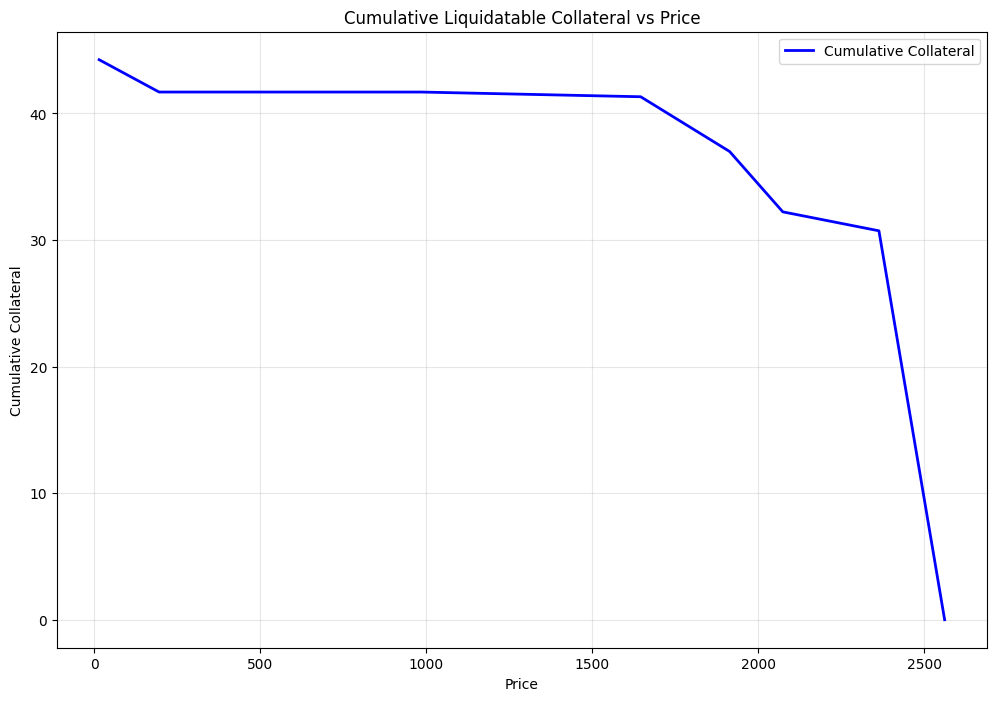

In [25]:
# Create a copy and sort by max_price in descending order
plot_df = output_liq_df.copy()
plot_df = plot_df.sort_values('max_price', ascending=False)

# Add cumulative sum column
plot_df['cum_collateral'] = plot_df['max_collateral_value'].cumsum()

plot_df['cum_debt'] = plot_df['debt'].cumsum()

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(plot_df['max_price'], plot_df['cum_collateral'], 
         label='Cumulative Collateral', 
         color='blue',
         linewidth=2)

plt.xlabel('Price')
plt.ylabel('Cumulative Collateral')
plt.title('Cumulative Liquidatable Collateral vs Price')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [26]:
curve_collateral, curve_debt = get_curve_liquidation_data(output_liq_df, PRICE_ASSUMPTION)

In [55]:
print("Curve Liquidatable Collateral:")
print(json.dumps(curve_collateral, indent=4))
print("\nCurve Liquidatable Debt:")
print(json.dumps(curve_debt, indent=4))

Curve Liquidatable Collateral:
{
    "wstETH": 0.015368727905653934
}

Curve Liquidatable Debt:
{
    "crvUSD": 41.34662312099985
}


In [27]:
def analyze_liquidatable_positions(
    aave_supported_asset_data: pd.DataFrame,
    aave_user_position_data: pd.DataFrame,
    asset_under_consideration: str,
    price_assumption: float,
    emode_lt: float,
    min_usd_threshold: float = 15000
) -> dict:
    """
    Analyzes liquidatable positions for given asset and price assumption.
    Returns both raw and USD values for liquidatable collateral and debt.
    """
    # Create price mapping
    new_price_mapping = {asset_under_consideration: price_assumption}
    price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))
    
    # Create asset mapping and get health ratios
    asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)
    
    # Get health ratio data for both normal and emode
    health_ratio_data_no_emode = create_health_ratio_data(aave_user_position_data, asset_mapping)
    health_ratio_data_emode = create_health_ratio_data_emode(aave_user_position_data, asset_mapping, emode_lt)
    health_ratio_data = pd.concat([health_ratio_data_no_emode, health_ratio_data_emode])
    
    # Get liquidatable positions
    total_liquidatable_collateral, total_liquidatable_debt = create_liquidatable_user_data(health_ratio_data)
    
    # Filter non-zero positions
    total_liquidatable_collateral = {k: v for k, v in total_liquidatable_collateral.items() if v > 0}
    total_liquidatable_debt = {k: v for k, v in total_liquidatable_debt.items() if v > 0}
    
    # Convert to USD
    total_liquidatable_collateral_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_collateral.items()
    }
    
    total_liquidatable_debt_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_debt.items()
    }
    
    # Filter by USD threshold
    filtered_collateral_usd = {k: v for k, v in total_liquidatable_collateral_usd.items() if v > min_usd_threshold}
    filtered_debt_usd = {k: v for k, v in total_liquidatable_debt_usd.items() if v > min_usd_threshold}
    
    # Reconstruct raw values from filtered USD values
    filtered_collateral = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_collateral_usd.items()
    }
    
    filtered_debt = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_debt_usd.items()
    }
    
    return filtered_collateral, filtered_debt

In [28]:
aave_collateral, aave_debt = analyze_liquidatable_positions(
    aave_supported_asset_data,
    aave_user_position_data,
    ASSET_UNDER_CONSIDERATION,
    PRICE_ASSUMPTION,
    AAVE_EMODE_LT
)

aave_collateral

{'wstETH': 2367.205693596857}

In [29]:
def merge_liquidation_data(aave_data: dict, curve_data: dict) -> dict:
    """
    Merge liquidation data from Aave and Curve protocols.
    """
    merged_data = aave_data.copy()  # Start with Aave data
    
    # Merge Curve data
    for token, amount in curve_data.items():
        if token in merged_data:
            merged_data[token] += amount
        else:
            merged_data[token] = amount
    
    return merged_data


In [56]:
print("Aave Liquidatable Collateral:")
print(json.dumps(aave_collateral, indent=4))
print("\nAave Liquidatable Debt:")
print(json.dumps(aave_debt, indent=4))

Aave Liquidatable Collateral:
{
    "wstETH": 2367.205693596857
}

Aave Liquidatable Debt:
{
    "WETH": 227.23529066483573,
    "USDC": 700856.236608,
    "DAI": 2654546.442447227,
    "USDT": 1509075.7506749996,
    "GHO": 85861.35665341486,
    "RPL": 2269.469508227577,
    "weETH": 500.1929821978981
}


In [30]:
# Merge collateral data
total_collateral = merge_liquidation_data(aave_collateral, curve_collateral)

# Merge debt data
total_debt = merge_liquidation_data(aave_debt, curve_debt)

print("Total Liquidatable Collateral:")
print(json.dumps(total_collateral, indent=4))
print("\nTotal Liquidatable Debt:")
print(json.dumps(total_debt, indent=4))

Total Liquidatable Collateral:
{
    "wstETH": 2367.221062324763
}

Total Liquidatable Debt:
{
    "WETH": 227.23529066483573,
    "USDC": 700856.236608,
    "DAI": 2654546.442447227,
    "USDT": 1509075.7506749996,
    "GHO": 85861.35665341486,
    "RPL": 2269.469508227577,
    "weETH": 500.1929821978981,
    "crvUSD": 41.34662312099985
}


In [31]:
EXCHANGE_RATE = asset_object.price/steth_token.price

total_collateral['stETH']=EXCHANGE_RATE*total_collateral['wstETH']
total_collateral.pop('wstETH', None)

print("Total Liquidatable Collateral:")
print(json.dumps(total_collateral, indent=4))
print("\nTotal Liquidatable Debt:")
print(json.dumps(total_debt, indent=4))

Total Liquidatable Collateral:
{
    "stETH": 2625.6659198511
}

Total Liquidatable Debt:
{
    "WETH": 227.23529066483573,
    "USDC": 700856.236608,
    "DAI": 2654546.442447227,
    "USDT": 1509075.7506749996,
    "GHO": 85861.35665341486,
    "RPL": 2269.469508227577,
    "weETH": 500.1929821978981,
    "crvUSD": 41.34662312099985
}


In [32]:
# Try to load existing trade_pair_hashmap or create new one
try:
    if os.path.exists('trade_pair_hashmap.pkl'):
        with open('trade_pair_hashmap.pkl', 'rb') as f:
            trade_pair_hashmap = pickle.load(f)
        print(f"Loaded existing trade_pair_hashmap with {len(trade_pair_hashmap)} pairs")
    else:
        trade_pair_hashmap = {}
        print("Created new empty trade_pair_hashmap")
except Exception as e:
    print(f"Error loading trade_pair_hashmap: {str(e)}")
    trade_pair_hashmap = {}
    print("Created new empty trade_pair_hashmap due to error")

Loaded existing trade_pair_hashmap with 107 pairs


In [33]:
# FLASHLOAN_ASSET_SYMBOLS = ['WETH']
FLASHLOAN_ASSET_SYMBOLS = ['USDC', 'USDT', 'DAI', 'WETH']

# Create sets for easier lookup
flashloan_assets = set(FLASHLOAN_ASSET_SYMBOLS)
liquidatable_debt_assets = set(total_debt.keys())
liquidatable_collateral_assets = set(total_collateral.keys())

# Function to create and store PairDTO if it doesn't exist
def create_and_store_pair(sell_token, buy_token, trade_pair_hashmap):
    if sell_token != buy_token:
        key = f"{sell_token}-{buy_token}"
        if key not in trade_pair_hashmap:
            
            print(f"Creating pair: {sell_token} -> {buy_token}")
            
            pair_dto = PairDTO(
                sell_token=aave_asset_object_dict[sell_token],
                buy_token=aave_asset_object_dict[buy_token],
                network=ETHEREUM_DTO
            )
            trade_pair_hashmap[key] = pair_dto
            return 1
    return 0

# Set 1: Flashloan assets as sell, liquidatable debt as buy
new_pairs_count = 0
total_pairs_set1 = len(flashloan_assets) * len(liquidatable_debt_assets)
for sell_token, buy_token in tqdm(product(flashloan_assets, liquidatable_debt_assets), 
                                  total=total_pairs_set1, 
                                  desc="Creating Set 1 PairDTO objects"):
    new_pairs_count += create_and_store_pair(sell_token, buy_token, trade_pair_hashmap)

# Set 2: Liquidatable collateral as sell, flashloan assets as buy
total_pairs_set2 = len(liquidatable_collateral_assets) * len(flashloan_assets)
for sell_token, buy_token in tqdm(product(liquidatable_collateral_assets, flashloan_assets), 
                                  total=total_pairs_set2, 
                                  desc="Creating Set 2 PairDTO objects"):
    new_pairs_count += create_and_store_pair(sell_token, buy_token, trade_pair_hashmap)

print(f"Total pairs in trade_pair_hashmap: {len(trade_pair_hashmap)}")
print(f"New pairs added: {new_pairs_count}")

# Save updated trade_pair_hashmap to a pickle file
import pickle
with open('trade_pair_hashmap.pkl', 'wb') as f:
    pickle.dump(trade_pair_hashmap, f)

Creating Set 2 PairDTO objects: 100%|██████████| 4/4 [00:00<?, ?it/s]

Total pairs in trade_pair_hashmap: 107
New pairs added: 0


C:\Users\dhruv\AppData\Local\Temp\ipykernel_63324\3834038245.py:22: RuntimeWarning: overflow encountered in exp
  y = (x * r) * (1 - (1/np.exp(exponent)))


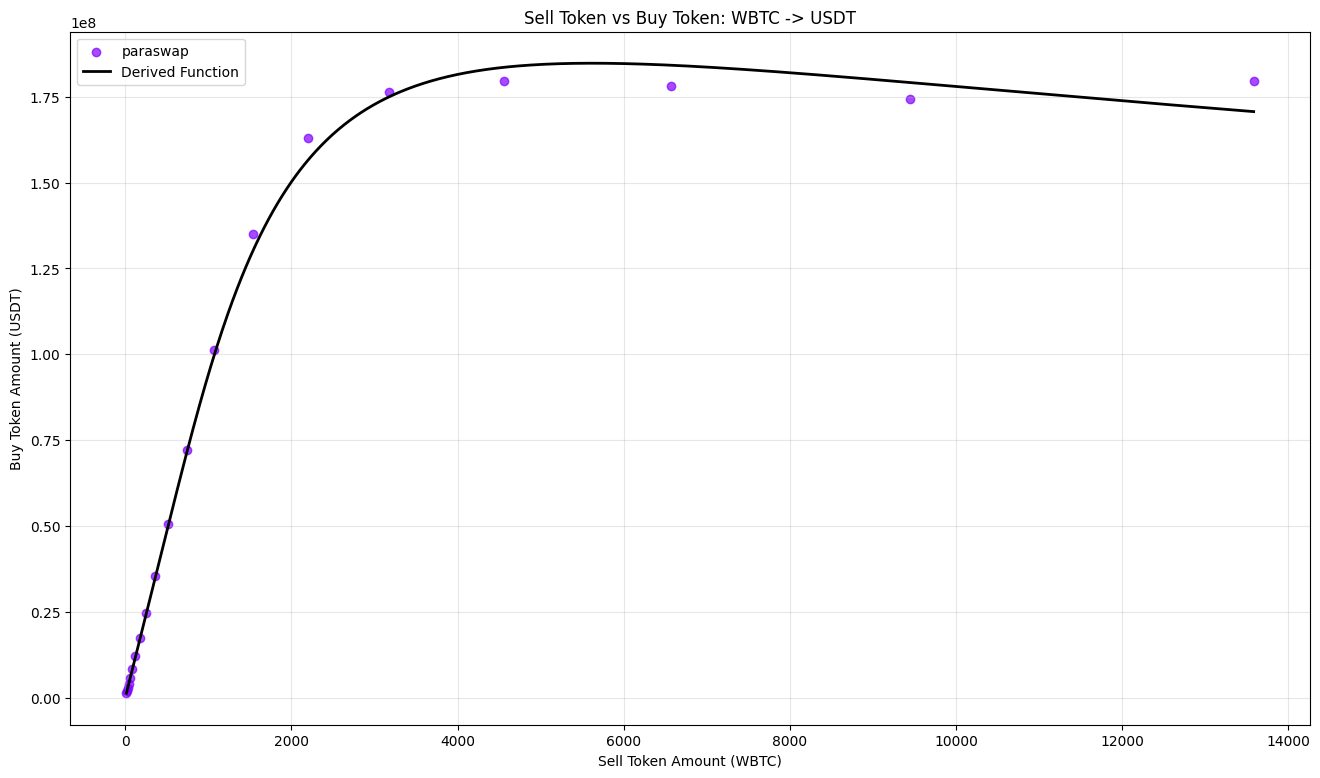


Function parameters:
Exchange Price (r): 97028.000000
k: 18238.618139
c: 1.238565


In [34]:

# Creata a copy of updated_trade_pair_hashmap
updated_trade_pair_hashmap_copy = trade_pair_hashmap.copy()


pair = updated_trade_pair_hashmap_copy["WBTC-USDT"]


def derived_func(x, r, k, c):
    """
    Calculate the value of y based on the given formula.

    Parameters:
        x (float): The value of x in the formula.
        r (float): The value of r in the formula.
        k (float): The value of k in the formula.
        c (float): The value of c in the formula.

    Returns:
        float: The calculated value of y.
    """
    exponent = k * (x ** -c)
    y = (x * r) * (1 - (1/np.exp(exponent)))
    return y

r = pair.exchange_price
k = pair.k
c = pair.c

pair_quotes_df = pair.quotes_df

# Create a new figure with a larger size
plt.figure(figsize=(16, 9))

# Plot scatter points for each dex_aggregator
aggregators = pair_quotes_df['dex_aggregator'].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(aggregators)))

sell_token_decimals = pair.sell_token.decimals
buy_token_decimals = pair.buy_token.decimals

for aggregator, color in zip(aggregators, colors):
    df_agg = pair_quotes_df[pair_quotes_df['dex_aggregator'] == aggregator]
    if not df_agg.empty:
        adjusted_sell_amount = df_agg['sell_token_amount'] / (10 ** sell_token_decimals)
        adjusted_buy_amount = df_agg['buy_token_amount'] / (10 ** buy_token_decimals)
        plt.scatter(adjusted_sell_amount, 
                    adjusted_buy_amount, 
                    label=aggregator, color=color, alpha=0.7)
    else:
        print(f"No data for aggregator: {aggregator}")

# Plot the derived function
if not pair_quotes_df.empty:
    x_min = pair_quotes_df['sell_token_amount'].min() / (10 ** sell_token_decimals)
    x_max = pair_quotes_df['sell_token_amount'].max() / (10 ** sell_token_decimals)
    x_range = np.linspace(x_min, x_max, 1000)
    y_derived = derived_func(x_range, r, k, c)
    plt.plot(x_range, y_derived, 'k-', label='Derived Function', linewidth=2)

plt.xlabel(f'Sell Token Amount ({pair.sell_token.symbol})')
plt.ylabel(f'Buy Token Amount ({pair.buy_token.symbol})')
plt.title(f'Sell Token vs Buy Token: {pair.sell_token.symbol} -> {pair.buy_token.symbol}')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.xscale('log')
# plt.yscale('log')
plt.show()

# Print the function parameters
print(f"\nFunction parameters:")
print(f"Exchange Price (r): {r:.6f}")
print(f"k: {k:.6f}")
print(f"c: {c:.6f}")

In [35]:
def plot_trading_pair_analysis(pair_symbol, trade_pair_hashmap):
    """
    Create a scatter plot of trading data with derived function for a specific trading pair.
    
    Parameters:
        pair_symbol (str): Trading pair symbol (e.g., "WBTC-USDT")
        trade_pair_hashmap (dict): Dictionary containing trading pair data
    
    Returns:
        None (displays plot)
    """
    # Get the trading pair data
    pair = trade_pair_hashmap[pair_symbol]
    
    def derived_func(x, r, k, c):
        """Calculate the value of y based on the given formula."""
        exponent = k * (x ** -c)
        y = (x * r) * (1 - (1/np.exp(exponent)))
        return y

    r = pair.exchange_price
    k = pair.k
    c = pair.c
    pair_quotes_df = pair.quotes_df

    # Create plot
    plt.figure(figsize=(16, 9))

    # Plot scatter points for each dex_aggregator
    aggregators = pair_quotes_df['dex_aggregator'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(aggregators)))

    sell_token_decimals = pair.sell_token.decimals
    buy_token_decimals = pair.buy_token.decimals

    # Plot data points for each aggregator
    for aggregator, color in zip(aggregators, colors):
        df_agg = pair_quotes_df[pair_quotes_df['dex_aggregator'] == aggregator]
        if not df_agg.empty:
            adjusted_sell_amount = df_agg['sell_token_amount'] / (10 ** sell_token_decimals)
            adjusted_buy_amount = df_agg['buy_token_amount'] / (10 ** buy_token_decimals)
            plt.scatter(adjusted_sell_amount, 
                       adjusted_buy_amount, 
                       label=aggregator, color=color, alpha=0.7)
        else:
            print(f"No data for aggregator: {aggregator}")

    # Plot derived function
    if not pair_quotes_df.empty:
        x_min = pair_quotes_df['sell_token_amount'].min() / (10 ** sell_token_decimals)
        x_max = pair_quotes_df['sell_token_amount'].max() / (10 ** sell_token_decimals)
        x_range = np.linspace(x_min, x_max, 1000)
        y_derived = derived_func(x_range, r, k, c)
        plt.plot(x_range, y_derived, 'k-', label='Derived Function', linewidth=2)

    # Set labels and title
    plt.xlabel(f'Sell Token Amount ({pair.sell_token.symbol})')
    plt.ylabel(f'Buy Token Amount ({pair.buy_token.symbol})')
    plt.title(f'Sell Token vs Buy Token: {pair.sell_token.symbol} -> {pair.buy_token.symbol}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print function parameters
    print(f"\nFunction parameters:")
    print(f"Exchange Price (r): {r:.6f}")
    print(f"k: {k:.6f}")
    print(f"c: {c:.6f}")

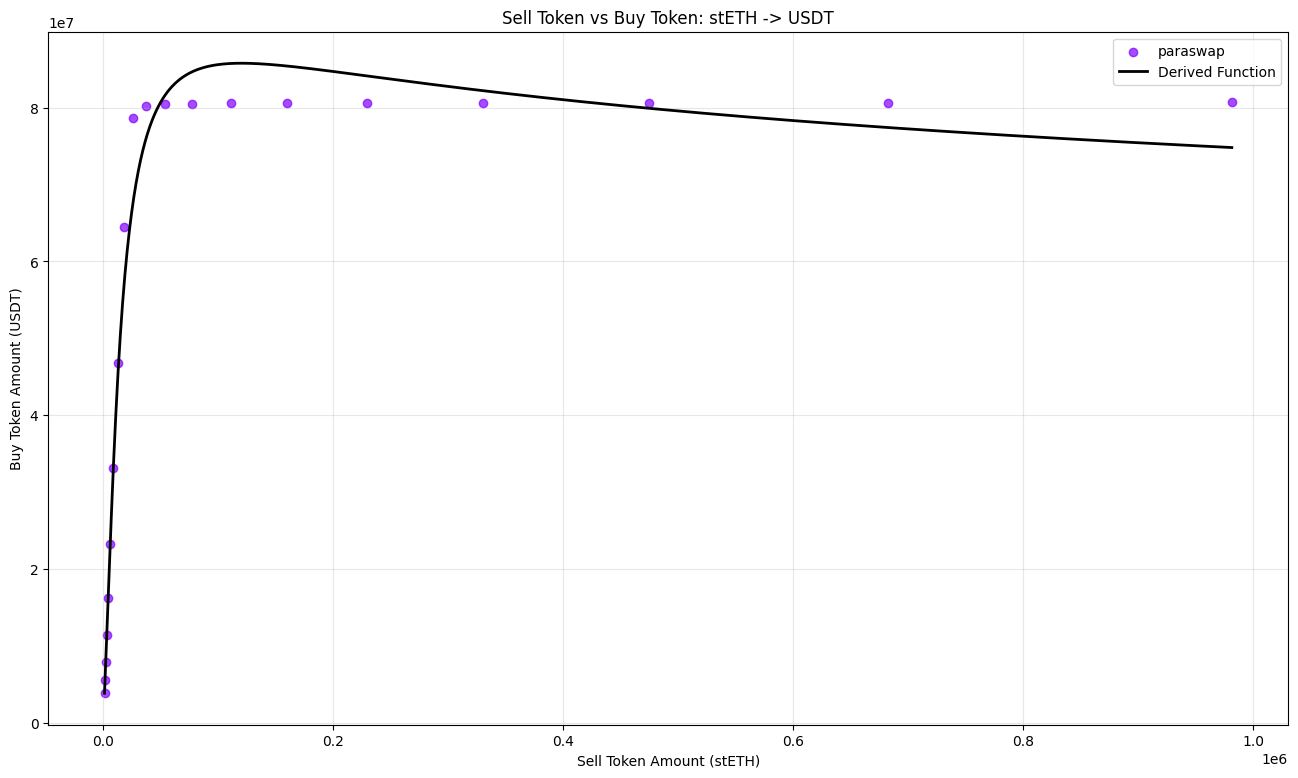


Function parameters:
Exchange Price (r): 3929.130000
k: 84614.276685
c: 1.107401


In [53]:
plot_trading_pair_analysis("stETH-USDT", trade_pair_hashmap)

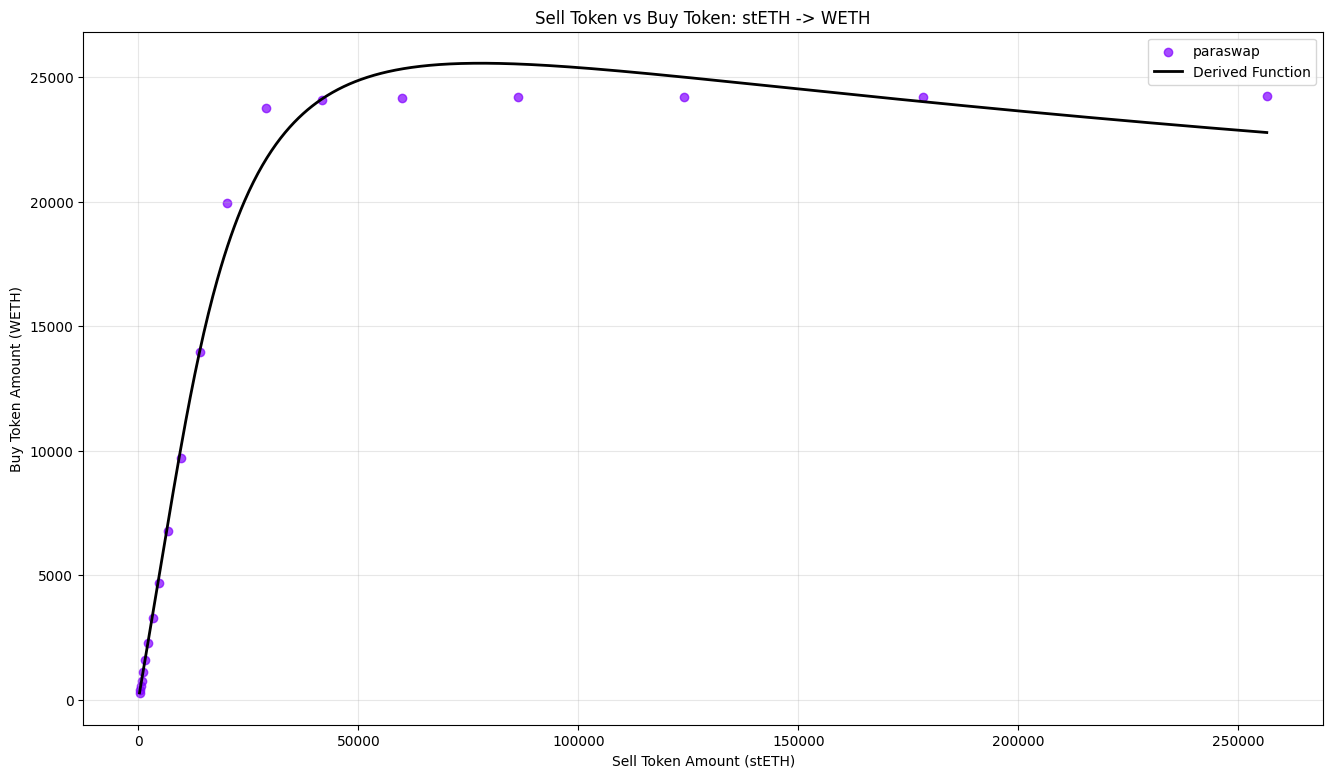


Function parameters:
Exchange Price (r): 1.057471
k: 312556.945963
c: 1.211274


In [54]:
plot_trading_pair_analysis("stETH-WETH", trade_pair_hashmap)

In [38]:
# Create price mapping
new_price_mapping = {ASSET_UNDER_CONSIDERATION: PRICE_ASSUMPTION}
price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))

# Create asset mapping and get health ratios
asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)

In [42]:
asset_mapping['stETH'] = {}
asset_mapping['stETH']['price'] = steth_token.price
asset_mapping['stETH']['liquidationThreshold'] = asset_mapping['wstETH']['liquidationThreshold']

In [39]:
def construct_new_price_mapping(asset_mapping, 
                                new_price_mapping,
                                total_liquidatable_collateral,
                                total_liquidatable_debt):
    
    output_mapping = {}
    
    # Extract keys from total_liquidatable_collateral and total_liquidatable_debt and add to separate sets
    liquidatable_collateral_assets = set(total_liquidatable_collateral.keys())
    liquidatable_debt_assets = set(total_liquidatable_debt.keys())
    
    # Join liquidatable_collateral_assets and liquidatable_debt_assets and remove duplicates
    liquidatable_assets = liquidatable_collateral_assets.union(liquidatable_debt_assets)    
    
    for asset in liquidatable_assets:
        if asset in new_price_mapping:
            price = new_price_mapping[asset]
            
            output_mapping[asset] = price
        else:
            price = asset_mapping[asset]['price']
            output_mapping[asset] = price
    
    for asset in FLASHLOAN_ASSET_SYMBOLS:
        price = asset_mapping[asset]['price']
        output_mapping[asset] = price
            
    return output_mapping



In [43]:
new_broad_price_mapping = construct_new_price_mapping(asset_mapping, new_price_mapping, total_collateral, total_debt)


In [44]:
new_broad_price_mapping = {}

In [45]:
updated_trade_pair_hashmap = update_trade_pair_exchange_price(trade_pair_hashmap, new_broad_price_mapping)


In [46]:
asset_mapping

{'WETH': {'price': 3715.59, 'liquidationThreshold': 0.83},
 'wstETH': {'price': 3742.1335, 'liquidationThreshold': 0.81},
 'WBTC': {'price': 97028.0, 'liquidationThreshold': 0.78},
 'USDC': {'price': 0.999451, 'liquidationThreshold': 0.78},
 'DAI': {'price': 1.0, 'liquidationThreshold': 0.77},
 'LINK': {'price': 22.48, 'liquidationThreshold': 0.71},
 'AAVE': {'price': 256.34, 'liquidationThreshold': 0.73},
 'cbETH': {'price': 4026.01, 'liquidationThreshold': 0.79},
 'USDT': {'price': 1.0, 'liquidationThreshold': 0.78},
 'rETH': {'price': 4164.8, 'liquidationThreshold': 0.79},
 'LUSD': {'price': 0.998643, 'liquidationThreshold': 0.77},
 'CRV': {'price': 1.062, 'liquidationThreshold': 0.41},
 'MKR': {'price': 1881.12, 'liquidationThreshold': 0.7},
 'SNX': {'price': 2.77, 'liquidationThreshold': 0.65},
 'BAL': {'price': 3.24, 'liquidationThreshold': 0.59},
 'UNI': {'price': 15.73, 'liquidationThreshold': 0.74},
 'LDO': {'price': 1.82, 'liquidationThreshold': 0.5},
 'ENS': {'price': 33.564

In [57]:
liquidation_profits_df = scale_supply_and_create_liquidations(updated_trade_pair_hashmap, 
                                                              asset_mapping, 
                                                              total_collateral, 
                                                              total_debt,
                                                              0.02, 
                                                              6,
                                                              80)


{
    "stETH": 52.513318397022005
}
{
    "WETH": 4.544705813296715,
    "USDC": 14017.12473216,
    "DAI": 53090.92884894454,
    "USDT": 30181.515013499993,
    "GHO": 1717.2271330682972,
    "RPL": 45.38939016455154,
    "weETH": 10.003859643957963,
    "crvUSD": 0.8269324624199971
}
{
    "stETH": 52.513318397022005
}
{
    "WETH": 4.544705813296715,
    "USDC": 14017.12473216,
    "DAI": 53090.92884894454,
    "USDT": 30181.515013499993,
    "GHO": 1717.2271330682972,
    "RPL": 45.38939016455154,
    "weETH": 10.003859643957963,
    "crvUSD": 0.8269324624199971
}
{
    "stETH": 52.513318397022005
}
{
    "WETH": 4.544705813296715,
    "USDC": 14017.12473216,
    "DAI": 53090.92884894454,
    "USDT": 30181.515013499993,
    "GHO": 1717.2271330682972,
    "RPL": 45.38939016455154,
    "weETH": 10.003859643957963,
    "crvUSD": 0.8269324624199971
}
{
    "stETH": 52.513318397022005
}
{
    "WETH": 4.544705813296715,
    "USDC": 14017.12473216,
    "DAI": 53090.92884894454,
    "USDT

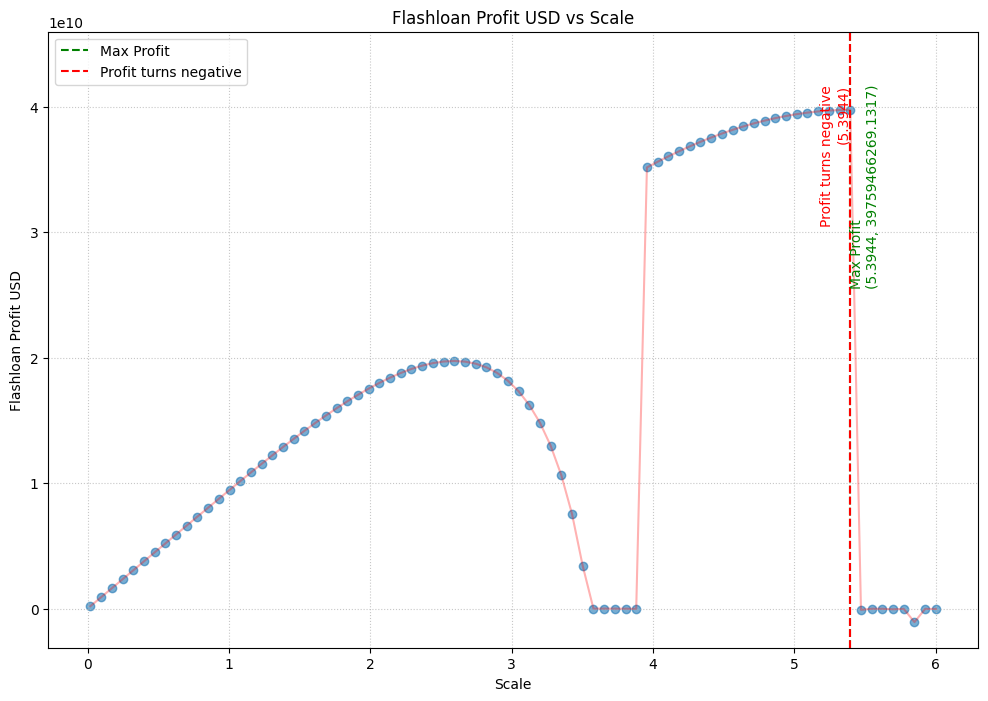

Maximum profit point: Scale = 5.39, Profit = 39759466269.13
Profit turns negative at: Scale = 5.39


In [58]:
# Sort the dataframe by scale
sorted_df = liquidation_profits_df.sort_values('scale')

# Find the point of maximum profit
max_profit_idx = sorted_df['flashloan_profit_usd'].idxmax()
max_profit_x = sorted_df.loc[max_profit_idx, 'scale']
max_profit_y = sorted_df.loc[max_profit_idx, 'flashloan_profit_usd']

# Find the point where profit turns negative
positive_profits = sorted_df[sorted_df['flashloan_profit_usd'] > 0]
if not positive_profits.empty:
    last_positive_idx = positive_profits.index[-1]
    zero_crossing_x = sorted_df.loc[last_positive_idx, 'scale']
    zero_crossing_y = 0
else:
    zero_crossing_x = zero_crossing_y = None

# Create the plot
plt.figure(figsize=(12, 8))
plt.scatter(sorted_df['scale'], sorted_df['flashloan_profit_usd'], alpha=0.6)
plt.plot(sorted_df['scale'], sorted_df['flashloan_profit_usd'], 'r-', alpha=0.3)

# Add vertical lines and annotations
plt.axvline(x=max_profit_x, color='g', linestyle='--', label='Max Profit')
plt.text(max_profit_x, plt.ylim()[1], f'Max Profit\n({max_profit_x:.4f}, {max_profit_y:.4f})', 
         rotation=90, va='top', ha='left', color='g')

if zero_crossing_x:
    plt.axvline(x=zero_crossing_x, color='r', linestyle='--', label='Profit turns negative')
    plt.text(zero_crossing_x, plt.ylim()[1], f'Profit turns negative\n({zero_crossing_x:.4f})', 
             rotation=90, va='top', ha='right', color='r')

# Adjust y-axis to give more space for labels
plt.ylim(plt.ylim()[0], plt.ylim()[1] * 1.1)

plt.xlabel('Scale')
plt.ylabel('Flashloan Profit USD')
plt.title('Flashloan Profit USD vs Scale')
plt.legend()

# Add grid for better readability
plt.grid(True, linestyle=':', alpha=0.7)

# Use scientific notation for y-axis if numbers are very large
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# plt.tight_layout()
plt.show()

# Print the exact values
print(f"Maximum profit point: Scale = {max_profit_x:.2f}, Profit = {max_profit_y:.2f}")
if zero_crossing_x:
    print(f"Profit turns negative at: Scale = {zero_crossing_x:.2f}")
else:
    print("Profit does not turn negative within the given data range.")

---